In [90]:
%matplotlib notebook

import numpy as np
import datetime
import math
import os 
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from netCDF4 import Dataset, num2date
from pynextsim.netcdf_list import NetcdfList
import xarray as xr
import scipy.ndimage

import cartopy.crs as ccrs

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
import matplotlib.gridspec as gridspec

In [110]:
# get thickness data from Moorings 

rootdir = '/cluster/work/users/rheinlender/breakup2013/outputs/breakup2013.ERA5.r10_20130101/'
filename='Moorings_2013m02.nc'

outpath_plots = '/cluster/work/users/rheinlender/plots/'

# get folder name
prefix = os.path.basename(os.path.normpath(rootdir))
print(prefix)

fl=rootdir+filename
print(fl)
    
# use xarray to open file
nc = xr.open_dataset(fl); 
nc_sel = nc.sel(time=slice('2013-02-01 06:00', '2013-02-01 18:00'))

lons = nc_sel.longitude[:]
lats = nc_sel.latitude[:]
var_model = nc_sel.sit.mean(axis=0)
print(var_model.values)

breakup2013.ERA5.r10_20130101
/cluster/work/users/rheinlender/breakup2013/outputs/breakup2013.ERA5.r10_20130101/Moorings_2013m02.nc
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [88]:
def get_transect(param,x0,x1,y0,y1):
    
    # get model variable (param) along a transect defined by start (x0,y0) and end-points (x1, y1)  
    
    # Make a line with length corresponding to number of pixels between start and end points...
    npix = int(np.hypot(x1-x0, y1-y0))
    x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, npix)
    #x, y = np.linspace(start[0], end[0], length), np.linspace(start[1], end[1],length)

    # Extract the values along the line, using cubic interpolation
    transect = param.transpose()[x.astype(np.int), y.astype(np.int)]

    return transect

def calc_distance(x0,x1,y0,y1):
    
    # calculates distance between two points along a transect and returns a vector

    R = 6373.0 #radius of the Earth

    # coordinates
    lon1=lons.values[x0,y0]
    lon2=lons.values[x1,y1]
    lat1=lats.values[x0,y0]
    lat2=lats.values[x1,y1]
    print(lon1, lon2, lat1, lat2)

    # convert
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)

    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # distance between points
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c

    xlen = len(transect)
    
    # make array showing distance from start to end 
    xtrans = np.linspace(0,distance, xlen)
    
    return xtrans
    

In [81]:
# Get ice thickness along cross section

param = var_model.values

# Define start and end points (lat/lon) for cross section:
x0, x1 = 320, 84 # southwest off Point Barrow
y0, y1 = 140 , 420 # east off Banks Island

# Make a line with "num" points...
transect = get_transect(param,x0,x1,y0,y1)

print(transect)

[2.243206   2.3023496  2.7673988  2.6628895  2.8379781  2.5554457
 2.581575   2.6089787  2.703558   2.703558   2.5676954  2.6336384
 2.87094    2.6318192  2.976502   2.976502   2.986825   3.0628273
 3.0628273  3.1428175  3.1148024  3.0491166  3.0809226  3.0904942
 2.992211   2.6649659  2.6649659  1.841255   1.7704589  1.962145
 2.121348   2.1240606  2.1240606  2.8307934  2.5842443  2.6081324
 2.5842443  2.544149   2.544149   2.526769   2.526769   2.5286071
 2.4914608  2.4914608  2.5018573  2.3473144  2.4751387  2.2667582
 2.1301317  2.1804361  1.7383523  2.468145   2.4472203  2.4371867
 2.452739   2.3746333  2.3488698  2.3931532  2.3421538  2.4898841
 2.622511   2.6080844  2.5619893  2.5712588  2.3491945  2.1744297
 2.1744297  2.357482   2.357482   2.357482   2.3258548  2.0749831
 1.9987931  1.974988   1.974988   2.3354707  2.3614707  2.3303108
 2.4493458  2.4403174  2.4378703  2.4092607  2.3787174  2.0184784
 2.1537123  2.669601   2.5101256  2.59624    2.744852   2.7015061
 2.6983166 

<IPython.core.display.Javascript object>


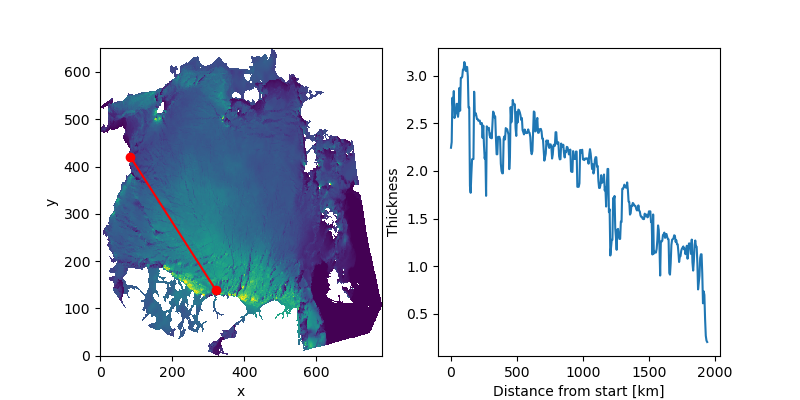

Text(0.5, 0, 'Distance from start [km]')

In [82]:
# Plot the result
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
var_model.plot.imshow(ax=ax[0], cmap='viridis', vmin=0, vmax=5, add_colorbar=False)

# show transect on map
ax[0].plot([x0, x1], [y0, y1], 'ro-')

# plot prameter interpolated along transect
ax[1].plot(xtrans, transect)
ax[1].set_ylabel("Thickness")
ax[1].set_xlabel("Distance from start [km]")


-106.61948 -57.04434 75.286026 82.81971
(240,) (240,)


/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


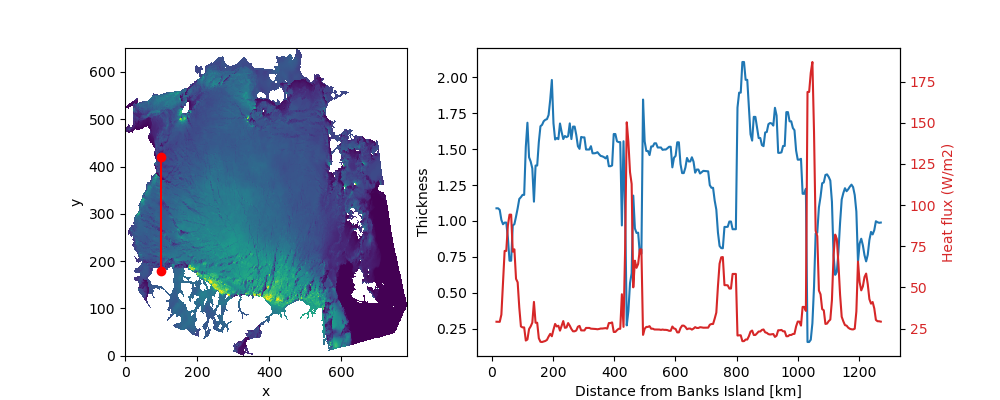

In [113]:
# Plot transect from Banks Island to Point Barrow

param = var_model.values

# Define start and end points (lat/lon) for cross section:
x0, x1 = 100, 100 # southwest off Point Barrow
y0, y1 = 180 , 420 # east off Banks Island

# transect of SIT
transect_sit = get_transect(param,x0,x1,y0,y1)

# transect of heat fluxes 
hfs=nc_sel.hfs.mean(axis=0).values
transect_hfs = get_transect(hfs,x0,x1,y0,y1)

xtrans = calc_distance(x0,x1,y0,y1)

print(transect_sit.shape, xtrans.shape)

# Plot the result
plt.close('all')
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[4, 6], hspace=0.1, wspace=0.2)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0:, 1:])

#plt.subplots_adjust(hspace=0.01, wspace=0.01, top=0.95, bottom=0.1, left=0.075, right=0.925)

# show transect on map
var_model.plot.imshow(ax=ax1, cmap='viridis', vmin=0, vmax=5, add_colorbar=False)
ax1.plot([x0, x1], [y0, y1], 'ro-')

# plot prameter interpolated along transect
ax2.plot(xtrans, transect_sit)
ax2.set_ylabel("Thickness")
ax2.set_xlabel("Distance from Banks Island [km]")

ax2r = ax2.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2r.set_ylabel('Heat flux (W/m2)', color=color)  # we already handled the x-label with ax1
ax2r.plot(xtrans, transect_hfs, color=color)
ax2r.tick_params(axis='y', labelcolor=color)

# save figure
figname ='sit_hfs_transect_BeaufortSea_20130201_'+prefix+'.png'    
plt.savefig( outpath_plots+figname, dpi=150, bbox_inches='tight')